---
title: "Learning Functions with Conditional Neural Processes"
author: "Neerja Kasture"
date: 2025-08-25
format: html
categories: [Neural Process, Tutorial, Machine Learning]
---

### Introduction

Meta learning models help us 'learn how to learn'. They are models that can learn new tasks quickly from just a handful of examples. In this blog, we explore a simple but powerful framework for this: the Conditional Neural Process (CNP).

### Imports

In [36]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
import torch.optim as optim

np.random.seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Creating training data

Instead of training on a fixed dataset, our model learns by seeing functions. In every training step, we generate a new sine wave of the form $𝑦=𝑎sin(𝑥)$ where the amplitude $𝑎$ is randomly chosen from a uniform distribution in (-2,2). Then we randomly sample points from this function to be context points and target points.

In [38]:
def sine(x, a):
  return a * np.sin(x)

def create_training_data(func, num_points=20, num_context=10):
    a = np.random.uniform(-2,2) # randomly sample a
    x_all = np.random.uniform(-np.pi, np.pi, num_points)
    y_all = func(x_all, a)

    context_indices = np.random.choice(num_points, num_context, replace=False)
    x_context = x_all[context_indices]
    y_context = y_all[context_indices]

    # The rest are target points
    target_indices = np.setdiff1d(np.arange(num_points), context_indices)
    x_target = x_all[target_indices]
    y_target = y_all[target_indices]

    # Convert to PyTorch tensors
    x_context = torch.tensor(x_context, dtype=torch.float32).unsqueeze(-1)
    y_context = torch.tensor(y_context, dtype=torch.float32).unsqueeze(-1)
    x_target = torch.tensor(x_target, dtype=torch.float32).unsqueeze(-1)
    y_target = torch.tensor(y_target, dtype=torch.float32).unsqueeze(-1)

    return x_context, y_context, x_target, y_target

Lets visualize some of these functions.

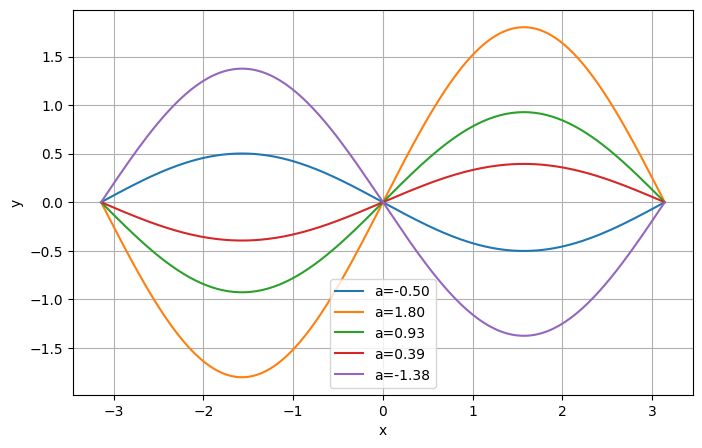

In [39]:
x = np.linspace(-np.pi, np.pi, 200)
plt.figure(figsize=(8, 5))

for i in range(5):
    a = np.random.uniform(-2, 2)
    y = sine(x, a)
    plt.plot(x, y, label=f"a={a:.2f}")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### The Model

A CNP has two main components:

1. Encoder : A neural network that takes in context pair $(x_i , y_i)$ and transforms them into representation vector $r_i$. To combine information from all context points, we take an average over all points and get a vector $r$ of same dimension as each vector $r_i$.
2. Decoder: A neural network that uses the representation $r$ to make predictions at target point $x_t$. We pass in concatenated $[r,x_t]$ as the input and the output is the predicted mean and variance of $y_t$. We normalize the value of sigma to make sure it is positive.

In [40]:
class Encoder(nn.Module):
  def __init__(self, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(2, 128) # x_context and y_context
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class Decoder(nn.Module):
  def __init__(self,r_dim):
    super().__init__()
    self.fc1 = nn.Linear(r_dim+1, 128) # r vector and x_target concatenated
    self.fc2 = nn.Linear(128, 2)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    mu,sigma = x.chunk(2, dim=-1)
    return mu, sigma

class ConditionalNeuralProcess(nn.Module):
  def __init__(self,r_dim):
    super().__init__()
    self.encoder = Encoder(r_dim)
    self.decoder = Decoder(r_dim)

  def forward(self,context_x,context_y,target_x):

    context_point = torch.cat([context_x, context_y], dim=-1)
    r_i = self.encoder(context_point)
    r =torch.mean(r_i,dim=0)
    num_target = target_x.shape[0]
    r_expanded = r.expand(num_target, -1)
    decoder_input = torch.cat([r_expanded, target_x], dim=-1)

    mu, sigma = self.decoder(decoder_input)
    sigma = 0.1 + 0.9 * torch.nn.functional.softplus(sigma)

    return mu, sigma

r_dim = 128
model = ConditionalNeuralProcess(r_dim)



The code below will help us visualize the model inputs and predictions.

In [41]:
def visualize_cnp_predictions(model, context_x, context_y, target_x, target_y):
    model.eval()

    with torch.no_grad():
        # Generate a dense range of x-values to plot the learned function smoothly
        x_plot = torch.linspace(target_x.min().item(), target_x.max().item(), 500).unsqueeze(-1)

        mu_pred, sigma_pred = model(context_x, context_y, x_plot)
        context_x_np = context_x.numpy()
        context_y_np = context_y.numpy()
        target_x_np = target_x.numpy()
        target_y_np = target_y.numpy()
        x_plot_np = x_plot.numpy()
        mu_pred_np = mu_pred.numpy()
        sigma_pred_np = sigma_pred.numpy()

    plt.figure(figsize=(10, 6))

    plt.scatter(context_x_np, context_y_np, c='red', label='Context Points', marker='o', s=100)

    plt.scatter(target_x_np, target_y_np, c='blue', label='True Target Points', marker='x', s=100)
    plt.plot(x_plot_np, mu_pred_np, color='green', linewidth=2, label='Predicted Mean')
    plt.fill_between(x_plot_np.squeeze(),
                     (mu_pred_np - 2 * sigma_pred_np).squeeze(),
                     (mu_pred_np + 2 * sigma_pred_np).squeeze(),
                     color='green', alpha=0.2, label='2σ Uncertainty')

    plt.title('Conditional Neural Process Predictions', fontsize=16)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


What does the model predict before training?

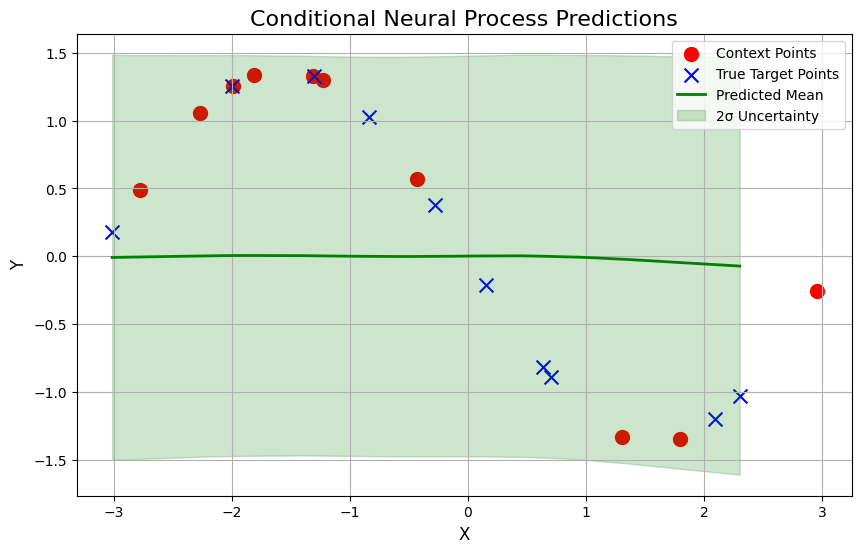

In [42]:
# for i in range(5):
x_context, y_context, x_target, y_target = create_training_data(sine)
visualize_cnp_predictions(model,x_context,y_context,x_target,y_target)

### Training

The model is trained by minimizing the negative log-likelihood (NLL) — encouraging the predicted distributions to assign high probability to the true target values.

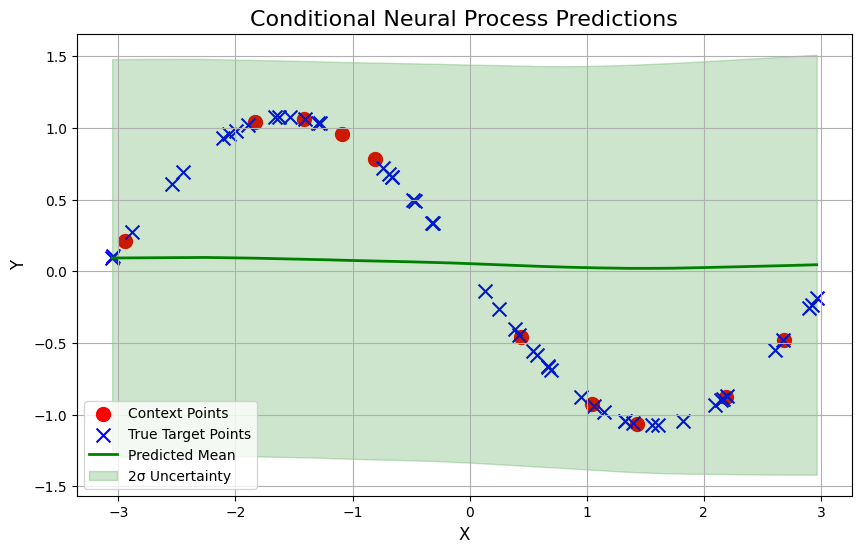

Epoch 0/2000, Loss: 1.2191544771194458


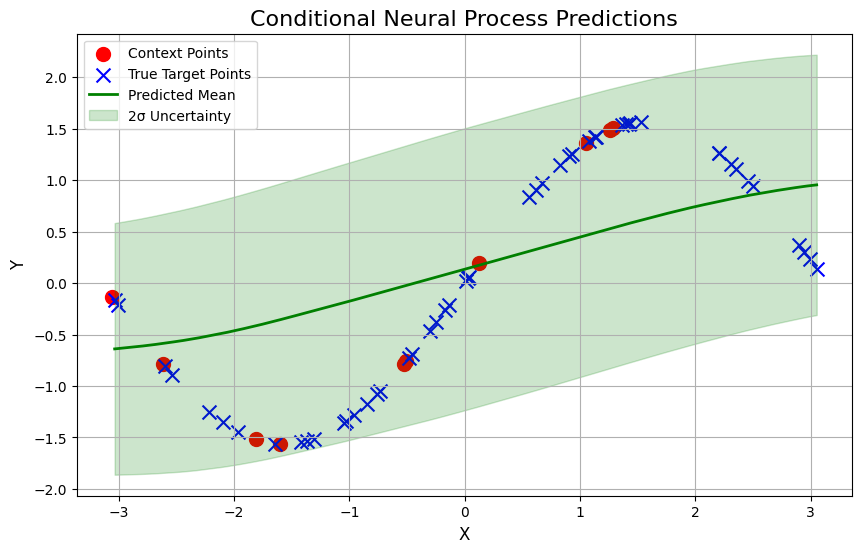

Epoch 100/2000, Loss: 1.1903642416000366


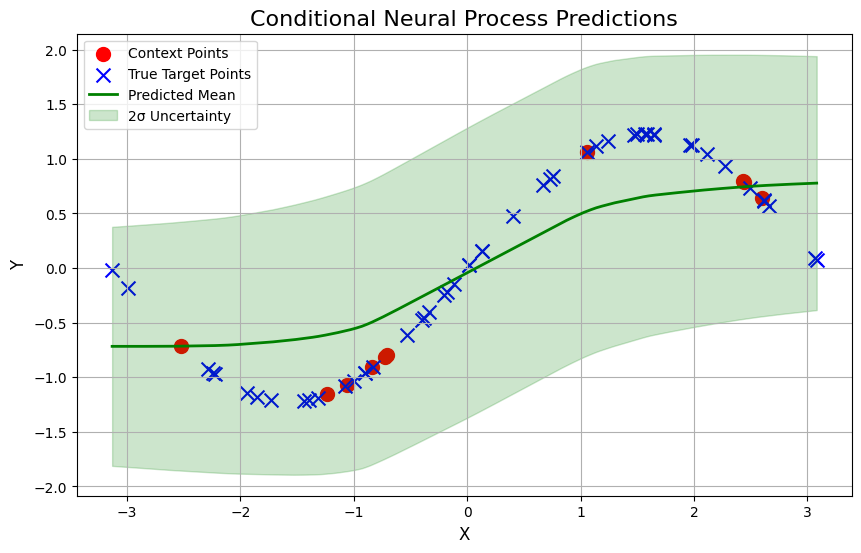

Epoch 200/2000, Loss: 0.7007207274436951


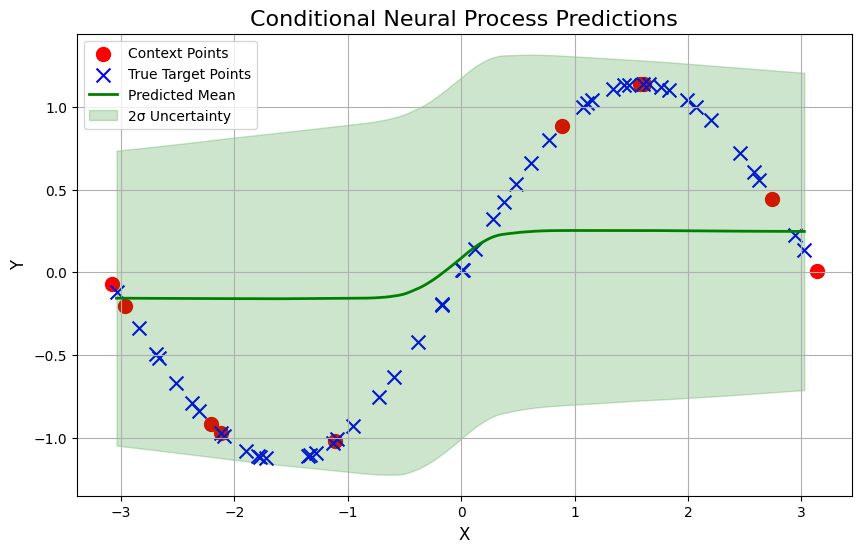

Epoch 300/2000, Loss: 1.5462225675582886


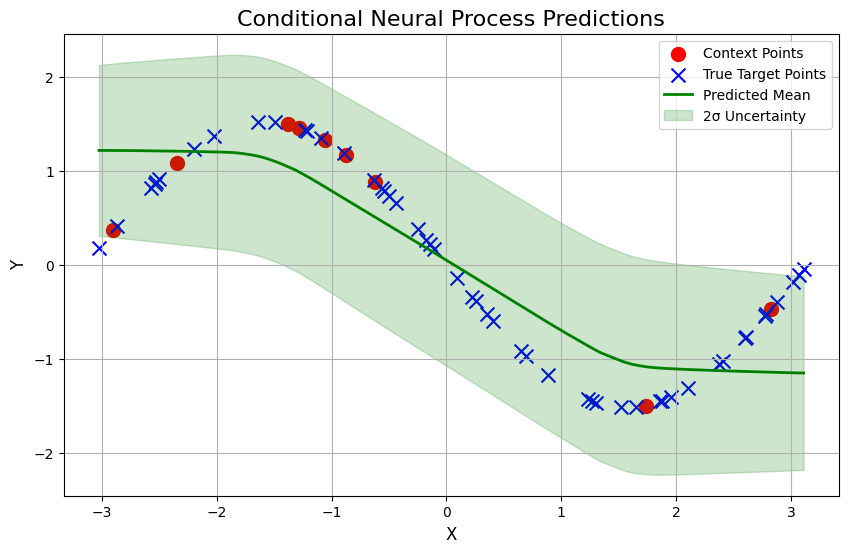

Epoch 400/2000, Loss: 0.7815963625907898


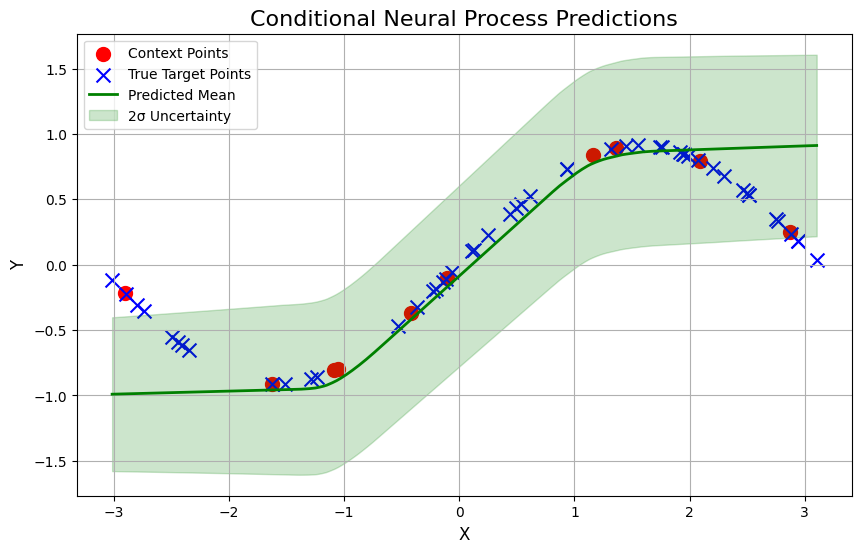

Epoch 500/2000, Loss: 0.7714107632637024


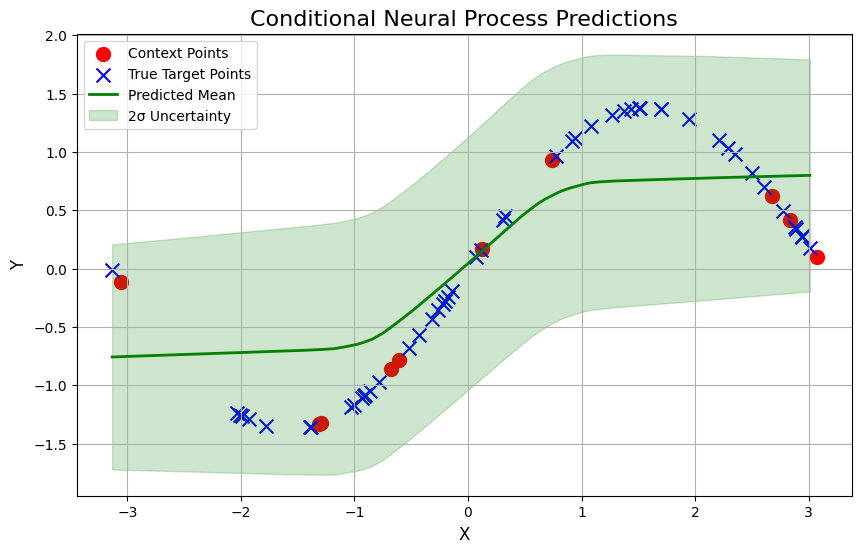

Epoch 600/2000, Loss: 0.6355094313621521


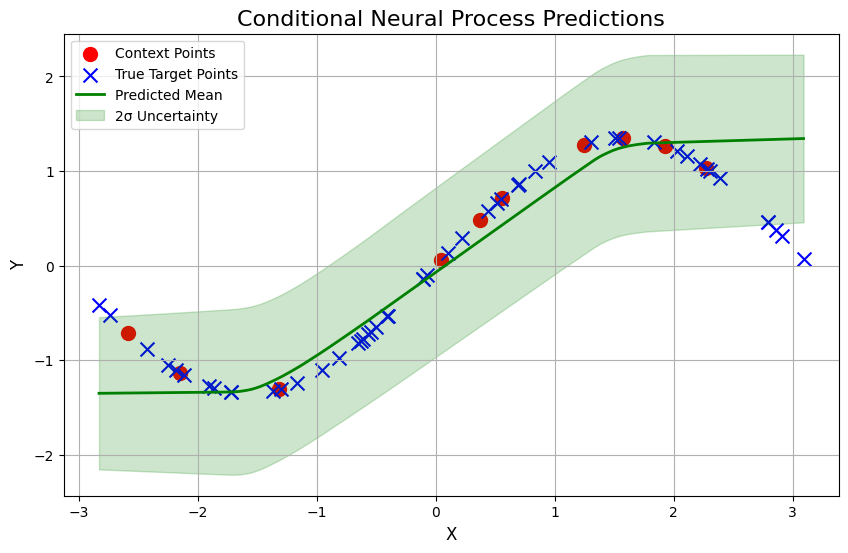

Epoch 700/2000, Loss: 0.5624711513519287


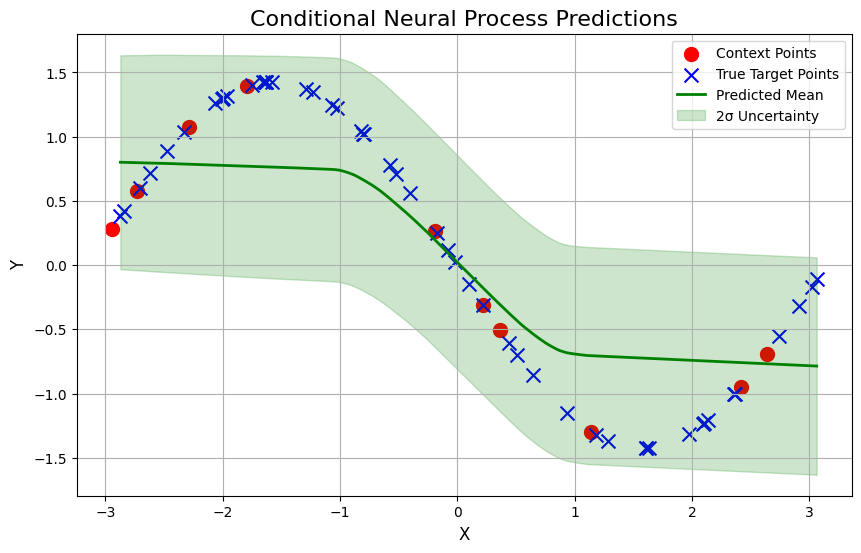

Epoch 800/2000, Loss: 0.6095244884490967


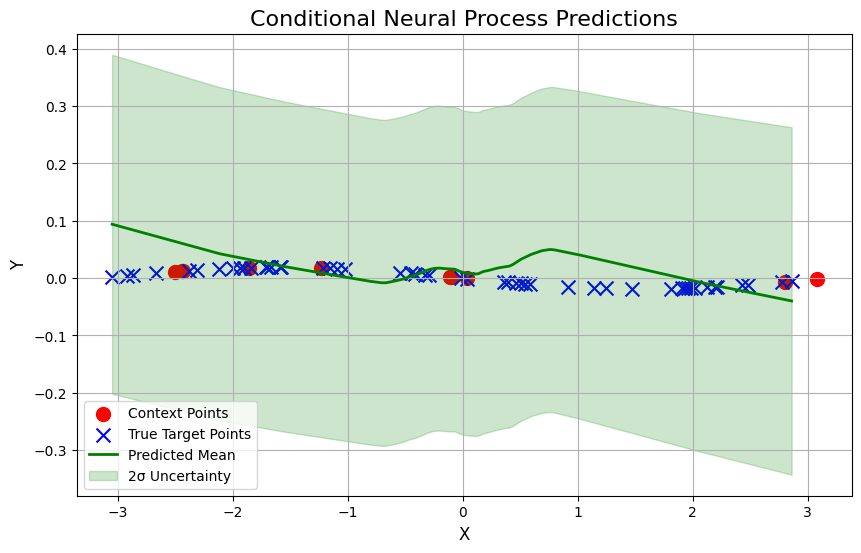

Epoch 900/2000, Loss: -0.9688698649406433


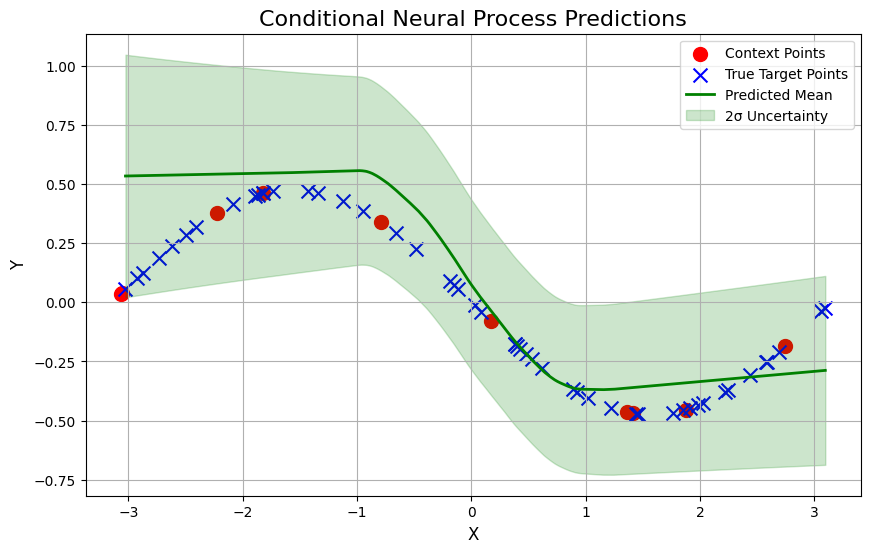

Epoch 1000/2000, Loss: -0.43185102939605713


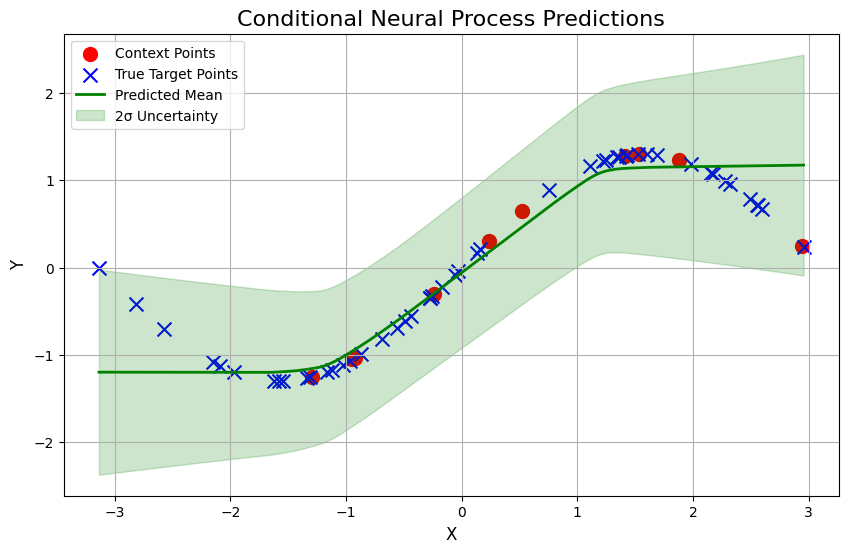

Epoch 1100/2000, Loss: 0.3317843973636627


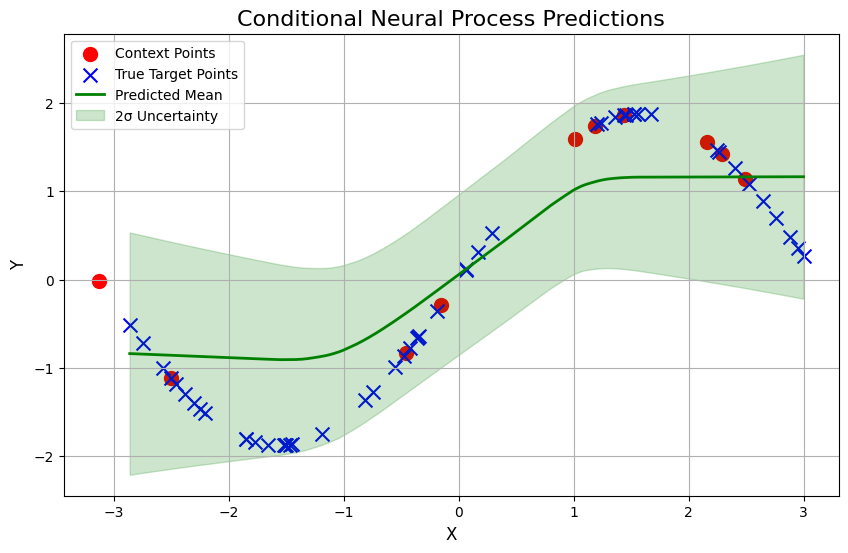

Epoch 1200/2000, Loss: 1.0584346055984497


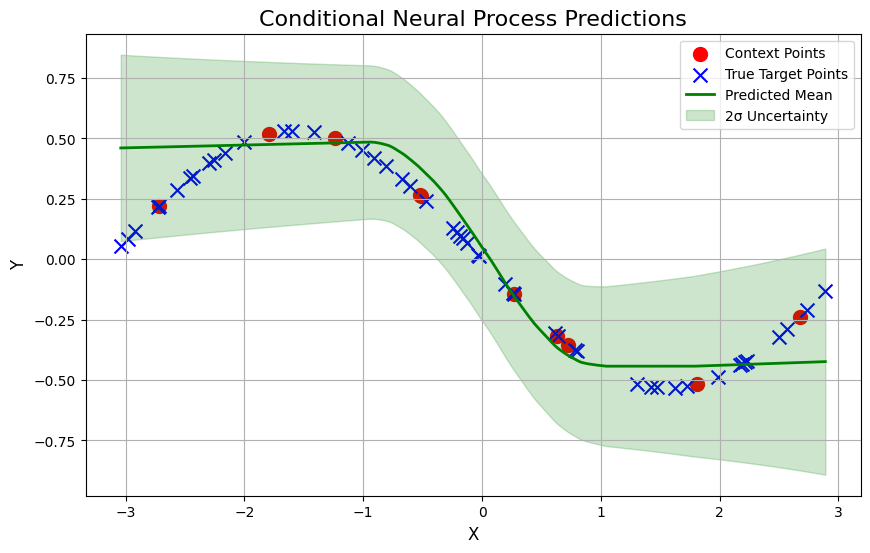

Epoch 1300/2000, Loss: -0.5391824841499329


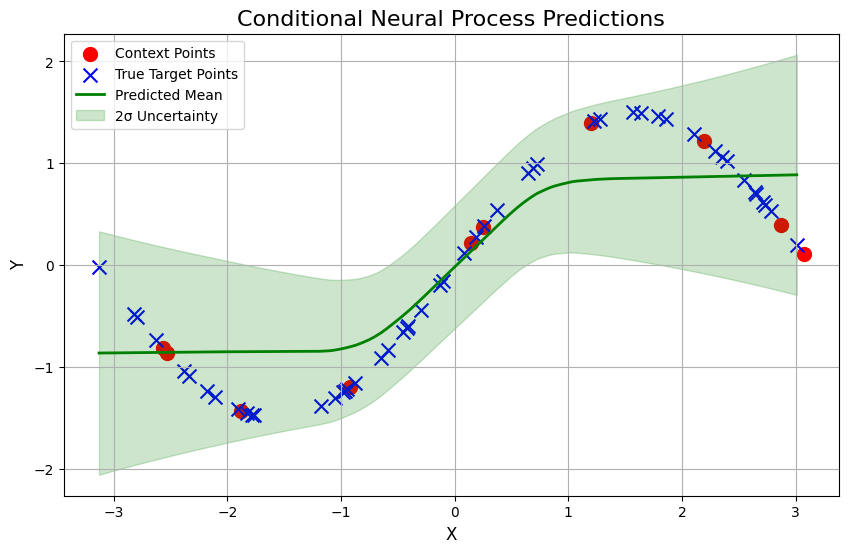

Epoch 1400/2000, Loss: 0.4801075756549835


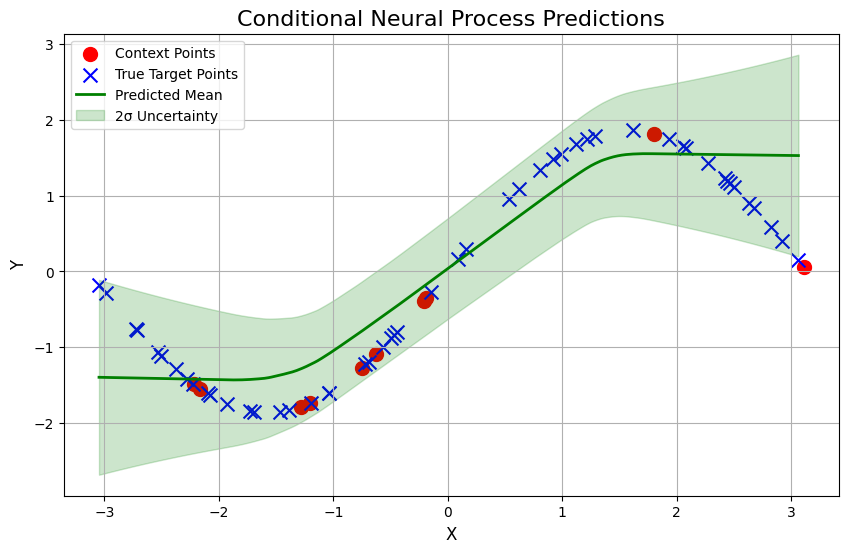

Epoch 1500/2000, Loss: 0.6704821586608887


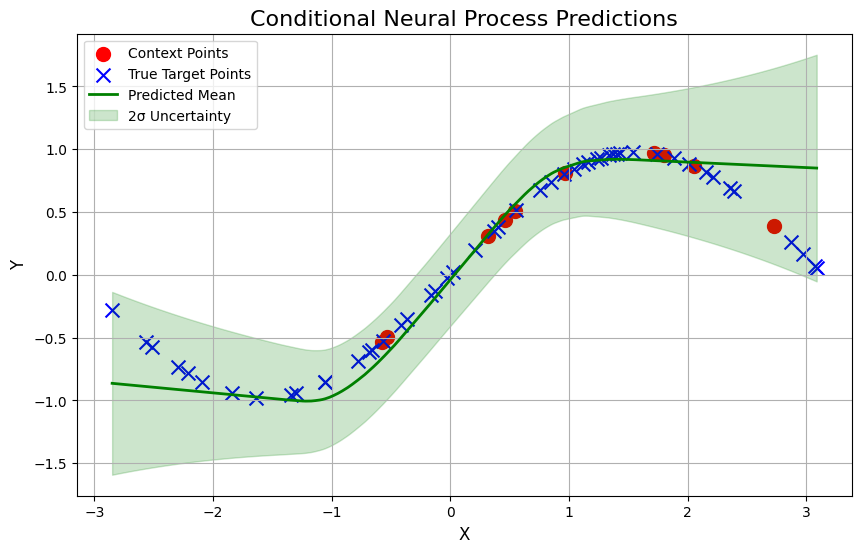

Epoch 1600/2000, Loss: -0.40198639035224915


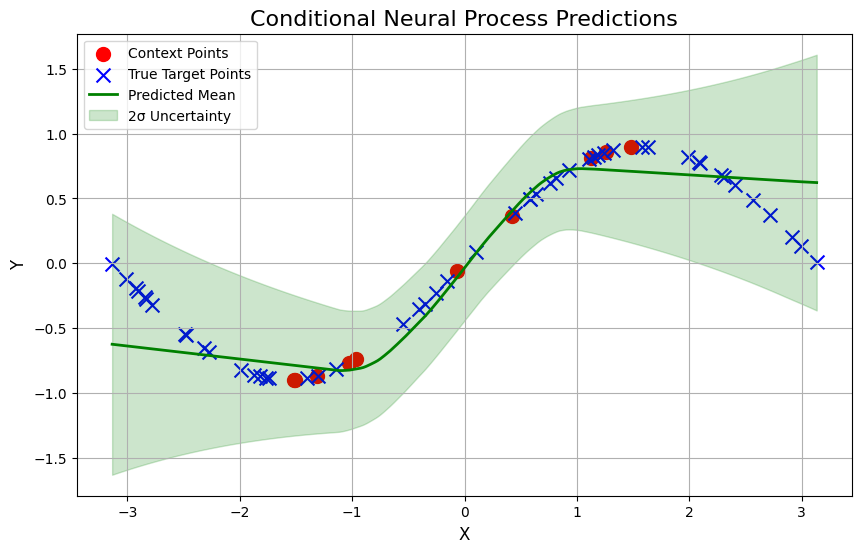

Epoch 1700/2000, Loss: -0.09618251770734787


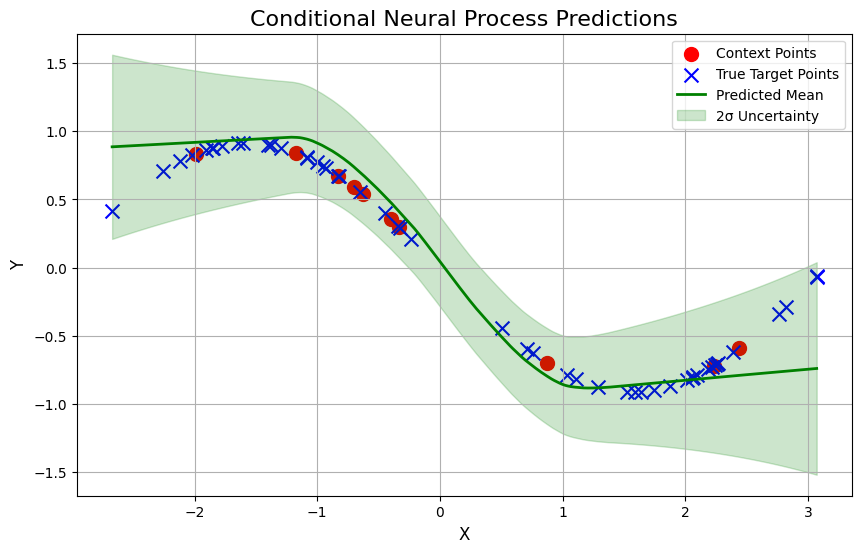

Epoch 1800/2000, Loss: -0.30808529257774353


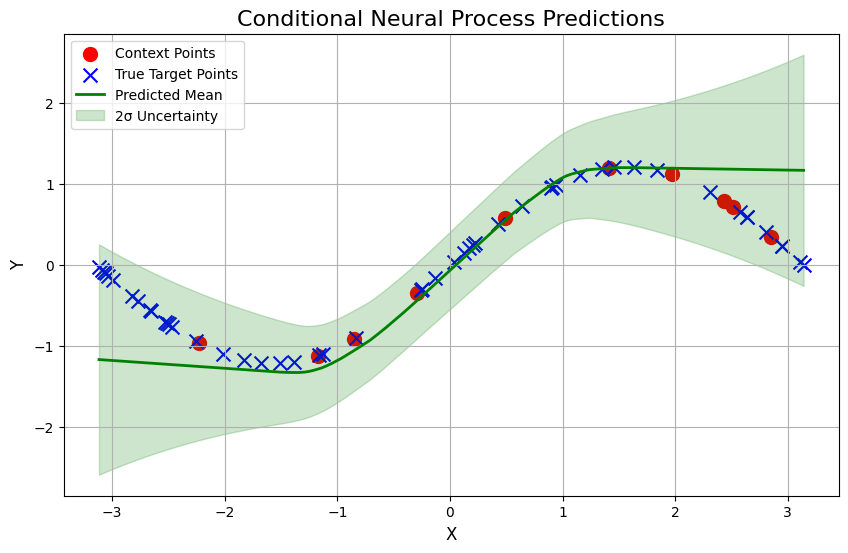

Epoch 1900/2000, Loss: 0.45030006766319275


In [43]:
r_dim = 128
model = ConditionalNeuralProcess(r_dim)

def NLL(mu_pred, sigma_pred, target_y):
    # Create a normal distribution with the predicted mean and standard deviation
    dist = Normal(mu_pred, sigma_pred)
    log_prob = dist.log_prob(target_y)
    loss = -torch.mean(log_prob)

    return loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 2000

for epoch in range(num_epochs):
    x_context, y_context, x_target, y_target = create_training_data(sine,60,10)
    optimizer.zero_grad()
    mu_pred, sigma_pred = model(x_context, y_context, x_target)
    loss = NLL(mu_pred, sigma_pred, y_target)

    loss.backward()
    optimizer.step()

    if (epoch) % 100 == 0:
      visualize_cnp_predictions(model,x_context,y_context,x_target,y_target)
      print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")


After training, the model is predicting a good approximation of our function.

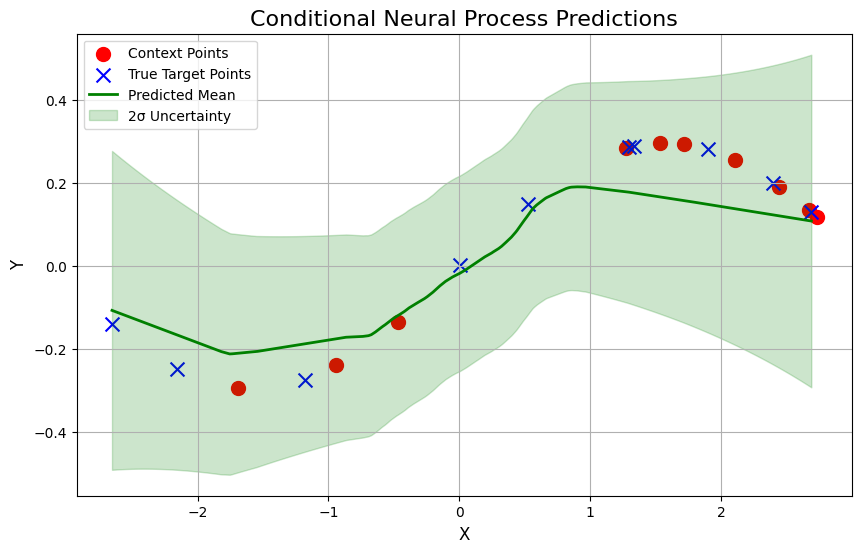

In [47]:
x_context, y_context, x_target, y_target = create_training_data(sine,20,10)
visualize_cnp_predictions(model,x_context,y_context,x_target,y_target)

I would say that CNPs are a rather simple approximation to neural processes. Their aggregator function being simply a mean may lose information and they do not model uncertainty as well, being a deterministic model.

Credits to https://kasparmartens.rbind.io/post/np/ and [Deepmind](https://colab.research.google.com/github/deepmind/neural-processes/blob/master/conditional_neural_process.ipynb#scrollTo=P3LJYP1Qh-jO)  for an excellent tutorial on this topic.